# Downloading Pretrained AgroBERT Model

In [1]:
!gdown --id 1KM6kf4VXb-lxq9u5WwMQed4dh2t2YKjr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KM6kf4VXb-lxq9u5WwMQed4dh2t2YKjr
To: /content/AgroBERT.model.tar.gz
100% 1.36G/1.36G [00:09<00:00, 144MB/s]


In [2]:
!tar -xzvf AgroBERT.model.tar.gz

AgroBERT.model/
AgroBERT.model/tf_model.h5
AgroBERT.model/tf_model.preproc


# Installing Dependencies

In [1]:
!pip install ktrain
!pip install geocoder
!pip install haversine
!python3 -m spacy download pt_core_news_sm
!python3 -m spacy download en_core_web_sm
!pip install folium
!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1
!pip install bertopic
import keras
import ktrain
from ktrain import text
import spacy
from spacy import displacy
import pt_core_news_sm
import en_core_web_sm
import pandas as pd
import numpy as np
import geocoder
from haversine import haversine, Unit
import folium
from folium.plugins import HeatMap
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import kneighbors_graph
import plotly.graph_objects as go
import networkx as nx
from networkx.algorithms import community

     |████████████████████████████████| 21.2 MB 2.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
     |████████████████████████████████| 12.0 MB 6.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-j78hkbpc
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-j78hkbpc
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.


# Loading Models

### AgroBERT base-model

In [2]:
agroBERT = ktrain.load_predictor('AgroBERT.model')

# How to use AgroBERT for Portuguese

### Sample dataset

In [3]:
!gdown --id 13tzAVYOSE82PI2AjyhsLH2LVJJGBvDJN

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13tzAVYOSE82PI2AjyhsLH2LVJJGBvDJN
To: /content/soybean_pt_br_sample.csv
100% 5.56M/5.56M [00:00<00:00, 188MB/s]


### Sentiment Analysis

In [4]:
text = 'Falta de chuva provoca perda de 1 milhão de toneladas de soja em MS'
print(agroBERT.predict(text))
agroBERT.explain(text)

NEGATIVE


In [5]:
df_texts_pt = pd.read_csv('soybean_pt_br_sample.csv')
df_texts_pt

,Date,text
0,30-12-2020,Soja acumula alta de quase 40% em 2020 e fecha...
1,29-12-2020,Soja testa os US$ 13/bushel na Bolsa de Chicag...
2,28-12-2020,Soja recua em Chicago com venda de fundos e po...
3,23-12-2020,Plantio de soja avança para 93% da área no RS;...
4,22-12-2020,Pátria Agronegócios reduz previsão para safra ...
...,...,...
1486,12-01-2015,Comercialização de soja safra 13/14 chega a 10...
1487,09-01-2015,"Colheita de soja em MT atinge 2% da área de 8,..."
1488,08-01-2015,"Soja sobe no interior do Brasil, apesar do fec..."
1489,07-01-2015,Soja: Preços sobem no Brasil e Rio Grande tem ...


In [6]:
df_texts_pt['sentiment'] = agroBERT.predict(df_texts_pt.text.to_list())

In [7]:
df_texts_pt[df_texts_pt.sentiment=='POSITIVE'].sample(5)

,Date,text,sentiment
819,13-09-2017,Soja: Chicago fecha com alta de dois dígitos j...,POSITIVE
1020,24-11-2016,Aprosoja PI divulga nota de repúdio sobre estu...,POSITIVE
934,29-03-2017,Soja: Referência para o disponível nos portos ...,POSITIVE
755,15-12-2017,Identificação precoce da ferrugem asiática na ...,POSITIVE
1389,03-06-2015,Atraso na compra de insumos eleva custo da soj...,POSITIVE


In [8]:
df_texts_pt[df_texts_pt.sentiment=='NEGATIVE'].sample(5)

,Date,text,sentiment
732,22-01-2018,Queda das vagens está relacionada a stress cli...,NEGATIVE
1244,04-01-2016,Soja: Com pressão do dólar e das poucas chuvas...,NEGATIVE
1482,16-01-2015,Soja: Mercado brasileiro tem semana negativa e...,NEGATIVE
875,26-06-2017,Governo do MS quer medidas mais restritivas co...,NEGATIVE
1487,09-01-2015,"Colheita de soja em MT atinge 2% da área de 8,...",NEGATIVE


### AgroBERT embeddings

Extracting embedding from 12-layer of the AgroBERT model

In [9]:
data_i = agroBERT.preproc.preprocess_test(df_texts_pt.text.to_list(), verbose=1)
embedding_model = keras.Model(inputs=agroBERT.model.input, outputs=agroBERT.model.get_layer('Encoder-12-FeedForward-Norm').output)
embeddings = embedding_model.predict(data_i[0]).mean(axis=1)
embeddings.shape

preprocessing test...
language: multi


(1491, 768)

In [10]:
df_texts_pt['embeddings']=list(embeddings)
df_texts_pt

,Date,text,sentiment,embeddings
0,30-12-2020,Soja acumula alta de quase 40% em 2020 e fecha...,POSITIVE,"[0.09259276, -0.065968774, -0.12343986, 0.0949..."
1,29-12-2020,Soja testa os US$ 13/bushel na Bolsa de Chicag...,POSITIVE,"[0.052811045, -0.0548711, -0.25104982, 0.15195..."
2,28-12-2020,Soja recua em Chicago com venda de fundos e po...,NEGATIVE,"[-0.03444448, -0.14155361, -0.30344212, 0.0889..."
3,23-12-2020,Plantio de soja avança para 93% da área no RS;...,POSITIVE,"[0.14343747, -0.20199096, 0.16472784, 0.038044..."
4,22-12-2020,Pátria Agronegócios reduz previsão para safra ...,POSITIVE,"[0.06712466, -0.11679957, -0.28229475, 0.15574..."
...,...,...,...,...
1486,12-01-2015,Comercialização de soja safra 13/14 chega a 10...,POSITIVE,"[0.12807913, -0.1257947, 0.114093006, 0.051017..."
1487,09-01-2015,"Colheita de soja em MT atinge 2% da área de 8,...",NEGATIVE,"[0.028170822, -0.08309182, -0.31646883, 0.1387..."
1488,08-01-2015,"Soja sobe no interior do Brasil, apesar do fec...",POSITIVE,"[0.0792513, -0.09319843, -0.25702128, 0.105914..."
1489,07-01-2015,Soja: Preços sobem no Brasil e Rio Grande tem ...,POSITIVE,"[0.037205126, -0.0655, -0.2911963, 0.10283562,..."


### Exploring AgroBERT embeddings

#### k-Nearest Neighbor Graph

In [69]:
def show_graph(G):
  ### ARESTAS
  edge_x = []
  edge_y = []

  # adicionando as coordenadas
  for edge in G.edges():
      x0, y0 = G.nodes[edge[0]]['pos']
      x1, y1 = G.nodes[edge[1]]['pos']
      edge_x.append(x0)
      edge_x.append(x1)
      edge_x.append(None)
      edge_y.append(y0)
      edge_y.append(y1)
      edge_y.append(None)

  # definindo cor e estilo das arestas
  edge_trace = go.Scatter(
      x=edge_x, y=edge_y,
      line=dict(width=2, color='#888'),
      hoverinfo='none',
      mode='lines')

  ### VÉRTICES
  node_x = []
  node_y = []

  # adicionando as coordenadas
  for node in G.nodes():
      x, y = G.nodes[node]['pos']
      node_x.append(x)
      node_y.append(y)

  # definindo cor e estilo dos vértices
  node_trace = go.Scatter(
      x=node_x, y=node_y,
      mode='markers',
      hoverinfo='text',
      marker=dict(
          size=10,
          line_width=2))


  # adicionando texto nos vértices
  node_text = []
  for node in G.nodes():
      node_text.append(G.nodes[node]['text'])
  node_trace.text = node_text

  # adicionando cores nos vértices de acordo com o cluster
  node_labels = []
  for node in G.nodes():
    node_labels.append(G.nodes[node]['sentiment'])
      
  node_trace.marker.color = node_labels

  # visualizando!
  fig = go.Figure(data=[edge_trace, node_trace],
              layout=go.Layout(
                  showlegend=False,
                  hovermode='closest',
                  margin=dict(b=20,l=5,r=5,t=40),
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                  )
  fig.show()

In [79]:
A = kneighbors_graph(embeddings, n_neighbors=1, metric="cosine")

G = nx.Graph(A)
pos = nx.spring_layout(G)

node_id=0
for index,row in df_texts_pt.iterrows():
    G.nodes[node_id]['text'] = row['text'][0:100]
    if(row['sentiment']=='POSITIVE'): G.nodes[node_id]['sentiment']=2;
    if(row['sentiment']=='NEGATIVE'): G.nodes[node_id]['sentiment']=1;
    G.nodes[node_id]['pos'] = pos[node_id]
    node_id+=1
show_graph(G)

#### Temporal Evolution over Sentiment Labels
Label=POSITIVE

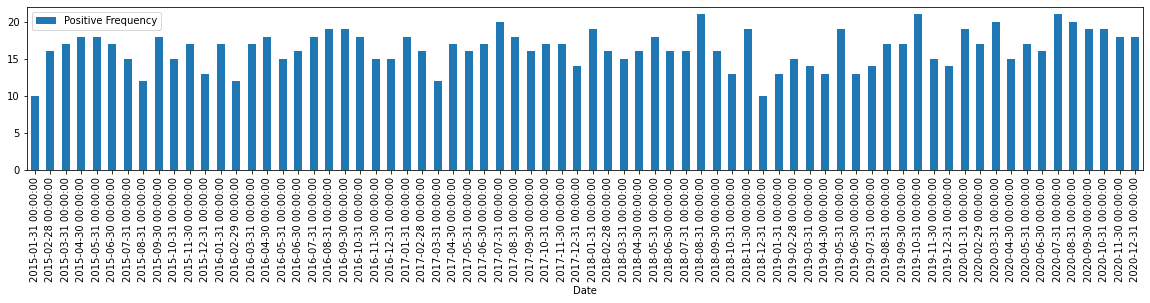

In [89]:
df_data = df_texts_pt[df_texts_pt.sentiment=='POSITIVE']
df_serie_sel = pd.DataFrame(df_data['text'])
df_serie_sel.index = pd.to_datetime(df_data['Date'],format='%d-%m-%Y')
df_serie_sel.columns=['Positive Frequency']

df_serie_sel = df_serie_sel.groupby(pd.Grouper(freq='M')).count()
df_serie_sel.plot.bar(figsize=(20,3))

#### Map and Heatmap over Sentiment Labels
Label=NEGATIVE

In [97]:
from tqdm.notebook import tqdm

nlp_pt = pt_core_news_sm.load()


L_locations = []
L_rows = []
for index,row in tqdm(df_texts_pt.iterrows(),total=len(df_texts_pt)):
  if row['sentiment']!='NEGATIVE': continue
  doc = nlp_pt(row['text'])
  locations = []
  for ent in doc.ents:
    if(ent.label_=='LOC'):
      locations.append(ent.text)
  if len(locations)==0: L_locations.append(None)
  else: L_locations.append(locations)
  
  L_rows.append(row)

  0%|          | 0/1491 [00:00<?, ?it/s]

In [98]:
df_map = pd.DataFrame(L_rows)
df_map['locations'] = L_locations
df_map = df_map.dropna()
df_map

,Date,text,sentiment,embeddings,locations
2,28-12-2020,Soja recua em Chicago com venda de fundos e po...,NEGATIVE,"[-0.03444448, -0.14155361, -0.30344212, 0.0889...","[Chicago, Argentina, Argentina, Agrinvest Comm..."
10,14-12-2020,"Soja fecha em alta na Bolsa de Chicago, mas re...",NEGATIVE,"[-0.0031796456, -0.10147399, -0.36204445, 0.07...","[Soja, BR, US$, Brasil, Itiquira, MT, Paranagu..."
26,20-11-2020,"Com mundo sem soja, mercado brasileiro tem mom...",NEGATIVE,"[0.016774895, -0.11936965, -0.3064506, 0.06359...","[Chicago, US$, US$, América do Sul, Brasil, Br..."
39,03-11-2020,Soja: Volume exportado em outubro cai 51% ante...,NEGATIVE,"[-0.0034066765, -0.12792598, -0.34264296, 0.15...","[Leticia PakulskiSão Paulo, Brasil, País, US$]"
40,30-10-2020,Sindicato de trabalhadores da indústria de soj...,NEGATIVE,"[0.0010259446, -0.09831405, -0.2968518, 0.0515...","[BUENOS AIRES, Argentina, San Lorenzo, Argentina]"
...,...,...,...,...,...
1481,19-01-2015,Soja: Preços no Brasil já caíram mais de 5% de...,NEGATIVE,"[0.020707963, -0.122546345, -0.35286847, 0.147...","[Brasil, Brasil, Chicago, Estados Unidos, Bras..."
1482,16-01-2015,Soja: Mercado brasileiro tem semana negativa e...,NEGATIVE,"[-0.08720197, -0.046930376, -0.3125069, 0.0061...","[Mercado brasileiro, Brasil, Notícias Agrícola..."
1483,15-01-2015,Soja cede forte em Chicago nesta 5ª feira e pr...,NEGATIVE,"[0.009766903, -0.12429913, -0.36170965, 0.1170...","[Chicago, Brasil, US$, EUA, Estados Unidos, EU..."
1485,13-01-2015,Soja perde o fôlego e fecha a 3ª feira com bai...,NEGATIVE,"[-0.011411649, -0.12307222, -0.2865081, 0.0915...","[América do Sul, USDA, China, América do Sul, ..."


In [ ]:
key='midianioliveira' # key demo para API do geonames   http://www.geonames.org/export/web-services.html

L_gps_data = []
L_rows = []

geo_cache = {}

counter = 0
for index,row in tqdm(df_map.iterrows(),total=len(df_map)):
  gps_data = []
  for geo_data in row['locations']:
    if geo_data in geo_cache:
        gps_data.append(geo_cache[geo_data])
    else:
        try:
            g = geocoder.geonames(geo_data, maxRows=1, key=key)
            for result in g:
                gps_data.append([result.lat,result.lng])
                geo_cache[geo_data]=[result.lat,result.lng]
        except Exception as e:
            print(e)

  L_rows.append(row)
  L_gps_data.append(gps_data)
  counter += 1
  #if counter > 100: break

In [106]:
df_map_gps = pd.DataFrame(L_rows)
df_map_gps['gps_data'] = L_gps_data
df_map_gps

,Date,text,sentiment,embeddings,locations,gps_data
2,28-12-2020,Soja recua em Chicago com venda de fundos e po...,NEGATIVE,"[-0.03444448, -0.14155361, -0.30344212, 0.0889...","[Chicago, Argentina, Argentina, Agrinvest Comm...","[[41.85003, -87.65005], [-34, -64], [-34, -64]..."
10,14-12-2020,"Soja fecha em alta na Bolsa de Chicago, mas re...",NEGATIVE,"[-0.0031796456, -0.10147399, -0.36204445, 0.07...","[Soja, BR, US$, Brasil, Itiquira, MT, Paranagu...","[[34.67534, 133.75091], [-26, -52], [-10, -55]..."
26,20-11-2020,"Com mundo sem soja, mercado brasileiro tem mom...",NEGATIVE,"[0.016774895, -0.11936965, -0.3064506, 0.06359...","[Chicago, US$, US$, América do Sul, Brasil, Br...","[[41.85003, -87.65005], [-14.60485, -57.65625]..."
39,03-11-2020,Soja: Volume exportado em outubro cai 51% ante...,NEGATIVE,"[-0.0034066765, -0.12792598, -0.34264296, 0.15...","[Leticia PakulskiSão Paulo, Brasil, País, US$]","[[-10, -55], [42.84998, -2.67268]]"
40,30-10-2020,Sindicato de trabalhadores da indústria de soj...,NEGATIVE,"[0.0010259446, -0.09831405, -0.2968518, 0.0515...","[BUENOS AIRES, Argentina, San Lorenzo, Argentina]","[[-34.61315, -58.37723], [-34, -64], [-25.3396..."
...,...,...,...,...,...,...
1481,19-01-2015,Soja: Preços no Brasil já caíram mais de 5% de...,NEGATIVE,"[0.020707963, -0.122546345, -0.35286847, 0.147...","[Brasil, Brasil, Chicago, Estados Unidos, Bras...","[[-10, -55], [-10, -55], [41.85003, -87.65005]..."
1482,16-01-2015,Soja: Mercado brasileiro tem semana negativa e...,NEGATIVE,"[-0.08720197, -0.046930376, -0.3125069, 0.0061...","[Mercado brasileiro, Brasil, Notícias Agrícola...","[[-10, -55], [-22.90642, -43.18223], [-25.5162..."
1483,15-01-2015,Soja cede forte em Chicago nesta 5ª feira e pr...,NEGATIVE,"[0.009766903, -0.12429913, -0.36170965, 0.1170...","[Chicago, Brasil, US$, EUA, Estados Unidos, EU...","[[41.85003, -87.65005], [-10, -55], [-14.60485..."
1485,13-01-2015,Soja perde o fôlego e fecha a 3ª feira com bai...,NEGATIVE,"[-0.011411649, -0.12307222, -0.2865081, 0.0915...","[América do Sul, USDA, China, América do Sul, ...","[[-14.60485, -57.65625], [71.23685, 72.15305],..."


In [117]:
# plotando eventos no mapa com heatmap
cache2 = {}
m = folium.Map(zoom_start=4)
data_heatmap = []
for index,row in df_map_gps.iterrows():
    
    for item in row['gps_data']:
        lat = float(item[0])
        lng = float(item[1])
        if str([lat,lng,1]) in cache2: continue
        cache2[str([lat,lng,1])]=1
        data_heatmap.append([lat,lng,1])

HeatMap(data_heatmap).add_to(m)

m